In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "knd"      # Used for tflite Filename
Training_Percentage = 0.2           
Epoch_Anz = 100
nb_classes = 2                     # move to 1. step
input_shape = (32, 20,3)
Batch_Size = 32

##########################################################################


In [3]:
from  bn.models.effnet import Effnet
import tensorflow as tf

model = Effnet(input_shape, nb_classes, activation_top='tanh')

model.compile(loss=tf.keras.losses.mean_squared_error, 
              optimizer="adam", metrics = ["accuracy"])

2022-05-03 15:22:23.727491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-03 15:22:23.727607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


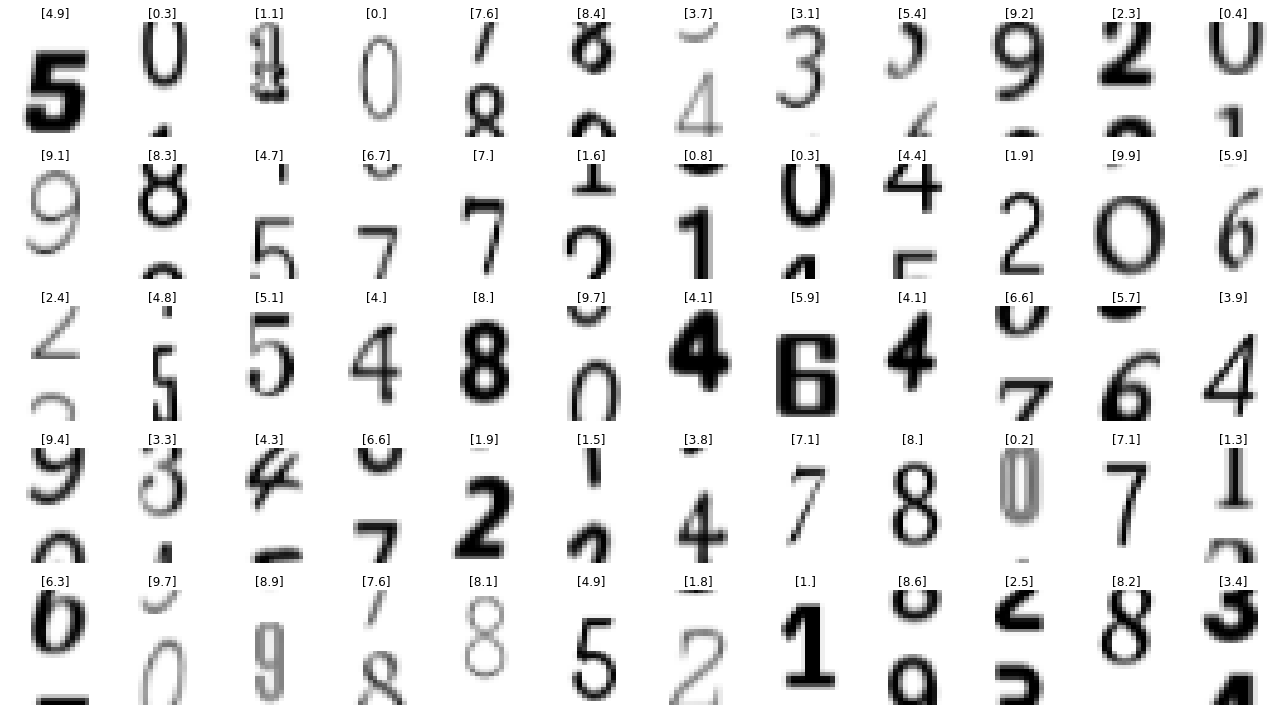

In [2]:
from bn.dataloading import tmnist_percentals
from bn.plot_functions import plot_dataset

x_train, y_train = tmnist_percentals()

plot_dataset(x_train, y_train)

In [76]:
y_train

array([[0.8],
       [2. ],
       [4.9],
       ...,
       [8.5],
       [3.4],
       [9.1]])

In [4]:
from bn.class_encoding import sin_cos_encoding
        
y_train = sin_cos_encoding(y_train)

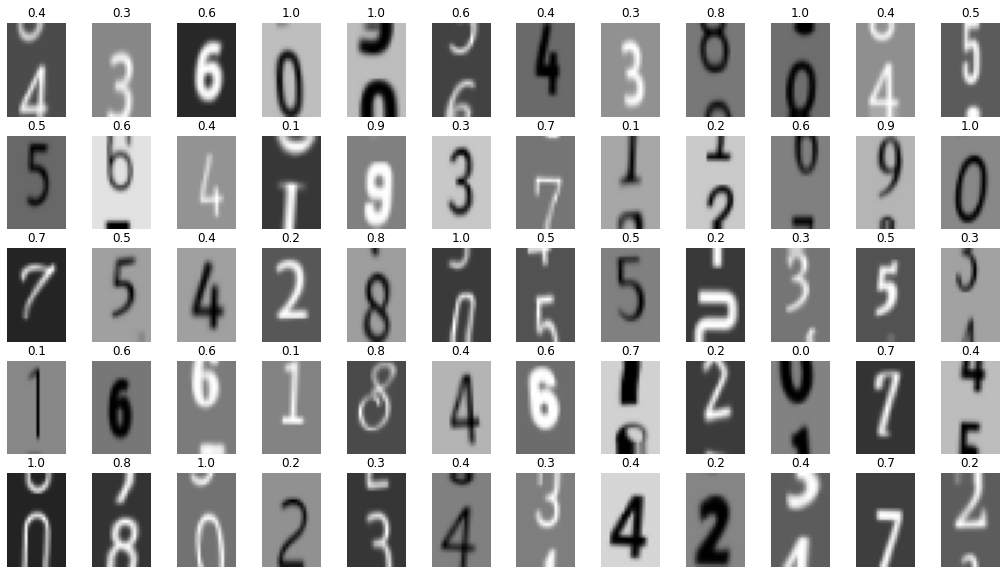

In [5]:
import numpy as np
from bn.augmentation import augmentation
from bn.plot_functions import plot_dataset_it
from sklearn.model_selection import train_test_split

# Split train and validation data 
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=Training_Percentage)

train_iterator = augmentation(x_train, y_train)
validation_iterator = augmentation(x_test, y_test)

plot_dataset_it(train_iterator)


Epoch 1/2


2022-05-03 15:22:45.930196: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-03 15:22:46.400679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6999/7000 [============================>.] - ETA: 0s - loss: 0.0698 - accuracy: 0.9400

2022-05-03 15:27:47.746002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7000/7000 [==============================] - 315s 45ms/step - loss: 0.0698 - accuracy: 0.9400 - val_loss: 0.0381 - val_accuracy: 0.9653
Epoch 2/2
7000/7000 [==============================] - 131s 19ms/step - loss: 0.0239 - accuracy: 0.9763 - val_loss: 0.0339 - val_accuracy: 0.9573


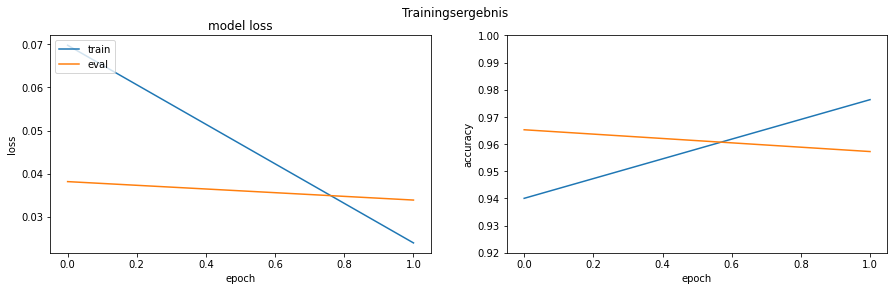

In [6]:
from bn.plot_functions import plot_acc_loss

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=32, 
                epochs = 2,
                verbose=1)

plot_acc_loss(history, "Trainingsergebnis")

In [20]:
from bn.class_encoding import sin_cos_encoding_revert
import numpy as np
from bn.plot_functions import plot_test_divergence

res = []
stat_Anz = []
stat_Abweichung = []
false_img = []
false_label = []
i = 0
deviation_max_list = 0.05
test_count = 100

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for x_test, y_test in zip(*sorted(zip(x_test, y_test))):
    if (test_count<0):
        break
    test_count = test_count - Batch_Size
           
    for (x, y) in zip(x_test, y_test):
            
        target_sin = y[0]
        target_cos = y[1]
        target = sin_cos_encoding_revert(y)
        classes = model.predict(x.reshape(1,32,20,3))
        
        out_sin = classes[0][0]  
        out_cos = classes[0][1]
        out_target = sin_cos_encoding_revert(classes[0])

        dev_sin = target_sin - out_sin
        dev_cos = target_cos - out_cos
        dev_target = target - out_target
        if abs(dev_target + 1) < abs(dev_target):
            out_target = out_target - 1
            dev_target = target - out_target
        else:
            if abs(dev_target - 1) < abs(dev_target):
                out_target = out_target + 1
                dev_target = target - out_target
                
        target_int = int ((target) * 10)
        stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
        stat_Anz[target_int] = stat_Anz[target_int] + 1
                
        res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
        if abs(dev_target) > deviation_max_list:
            lbl_text = "Expected: " + str(round(target*10,1)) + "\n Predicted: " + str(round(out_target*10,1)) +  "\n diff: " + str(round(dev_target*10,1))
            print("Exp: " + str(round(target*10,1)) + " Pred: " + str(round(out_target*10,1)) +  " diff: " + str(round(dev_target*10,1)))
            false_img.append(x)
            false_label.append(lbl_text)
    
for i in range(100):
    if (stat_Anz[i] != 0):
        stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res
print(len(false_img), len(false_label))
plot_dataset(np.array(false_img).astype(np.uint8), false_label, columns=11, rows=3)
print(res[:,4])
plot_test_divergence(res[:,3], res[:,4])


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [8]:
from PIL import Image 
import glob
import os

def ziffer_data_files():
    Input_dir='test_data'
    return  glob.glob(Input_dir + '/*.jpg') 

def ziffer_data(x_data, y_data, nb_classes):

    files = ziffer_data_files()

    for aktfile in files:
        base = os.path.basename(aktfile)
        target = base[0:1]
        if target == "N":
            category = 10                # NaN does not work --> convert to 10

        else:
            category = int(target)
        test_image = Image.open(aktfile).resize((20, 32))
        test_image = np.array(test_image, dtype="float32")

        # if only 10 classes, ignore the category 10
        if (nb_classes>10 or category<10):
            x_data.append(test_image)
            y_data.append(np.array([category]))
    return x_data, y_data

xz_test, yz_test = ziffer_data([],[], 11)

In [9]:
np.array(xz_test).shape
model.predict(np.array(xz_test))

array([[0.5783475 , 0.10734197]], dtype=float32)